In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# mlQTLs: algorithm for QTLs mapping (and feature selection??)

I want to develop an ensemble L1norm approach for QTLs mapping, but it can be used also for feature selection on regression problems (maybe).

I took the idea (especially for classification tasks) from [this
manuscript](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5260053/)

### QTL mapping (main functionality)
You should use Rqtl for simulating crosses

In [2]:
#import rpy2
%load_ext rpy2.ipython

Create cell with R code **BC dominant QTLs**

## Develop pipeline
The next cell hs the algorithm

Use of LassoCV

In [3]:
# main function
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample
from sklearn.datasets import make_regression
from sklearn.svm import LinearSVR
from sklearn.linear_model import LassoCV
from scipy import stats

def optimize_weights(X, y, cv):
    alphas = 1/(X.shape[0]*np.logspace(-5, 4, 10))
    model = LassoCV(alphas=alphas, cv = cv, random_state=42, 
                    precompute=True, positive=True, n_jobs=-1)
    model.fit(X,y)
    return model.coef_
    
def mlQTLs_analysis(X, y, n_estimators=500,
                    max_samples = 0.8, cv = 5, random_state=42):
    '''main function that will call the other functions'''
    all_w = []
    for i in range(n_estimators):
        # loop over the number of estimators
        X_res, y_res = resample(X, y,
                                n_samples=int(np.ceil(X.shape[0]*max_samples)),
                                replace=True, random_state=i*random_state)
        w = optimize_weights(X_res, y_res, cv=cv)
        all_w.append(w)
    # now you will need to:
        #1) Calculate the stability score for each feature
        #2) Sum the scores
        #3) for optimization purpose I will return the full  coeff_array
    all_w = np.array(all_w)
    w= np.sum(all_w, axis=0)
    bin_matrix = np.where(all_w>0, 1, 0)
    s_scores = np.sum(bin_matrix, axis=0)
    return w, s_scores

# Single dominant QTL

**Simulation**

    Backcross

    No. individuals:    250 

    No. phenotypes:     1 
    Percent phenotyped: 100 

    No. chromosomes:    5 
        Autosomes:      1 2 3 4 5 

    Total markers:      268 
    No. markers:        65 38 50 55 60 
    Percent genotyped:  100 
    Genotypes (%):      AA:50.3  AB:49.7 


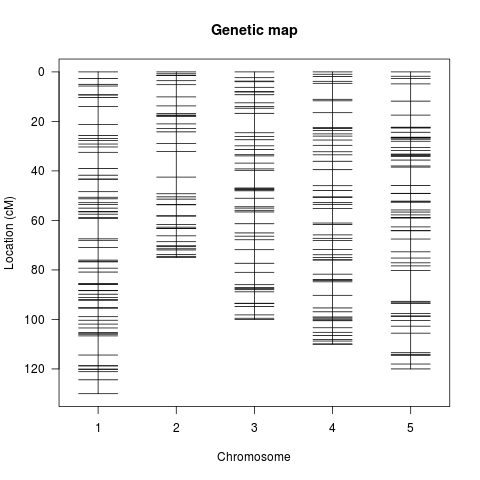

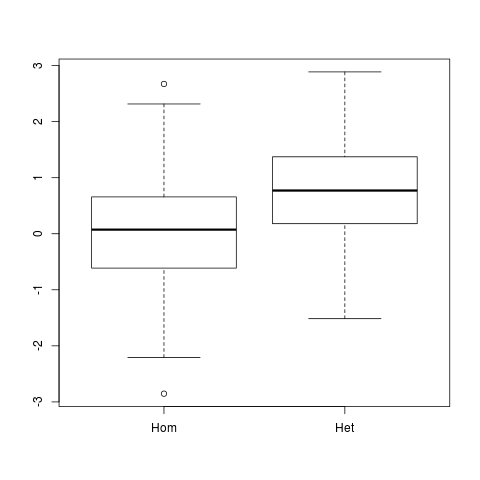

In [27]:
%%R
library(qtl)
L=c(130, 75, 100, 110, 120)
set.seed(101)
mapD=sim.map(L, ceiling(L/2), eq.spacing=F, include.x=F)
plot(mapD)
bc_model = rbind(c(3, 30, 0.6))
BC_cross = sim.cross(mapD, n.ind=250, type='bc', model = bc_model)
p1 = subset(BC_cross$pheno[,1], BC_cross$qtlgeno[,1]==1)
p2 = subset(BC_cross$pheno[,1], BC_cross$qtlgeno[,1]==2)
boxplot(p1, p2, names=c('Hom', 'Het'))
print(summary(BC_cross))
write.cross(BC_cross, format='csv', filestem='BC_dominant_cross')

**Evaluation on RQTL**

 --Read the following data:
	 250  individuals
	 268  markers
	 1  phenotypes
 --Cross type: bc 
    Backcross

    No. individuals:    250 

    No. phenotypes:     1 
    Percent phenotyped: 100 

    No. chromosomes:    5 
        Autosomes:      1 2 3 4 5 

    Total markers:      268 
    No. markers:        65 38 50 55 60 
    Percent genotyped:  100 
    Genotypes (%):      AA:50.3  AB:49.7 
      chr   pos   lod
D1M2    1  2.62 1.047
D2M1    2  0.00 0.196
D3M19   3 33.94 6.744
D4M33   4 73.88 0.411
D5M15   5 27.14 0.368


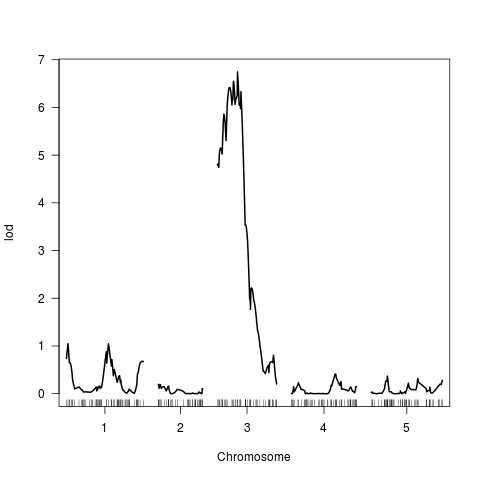

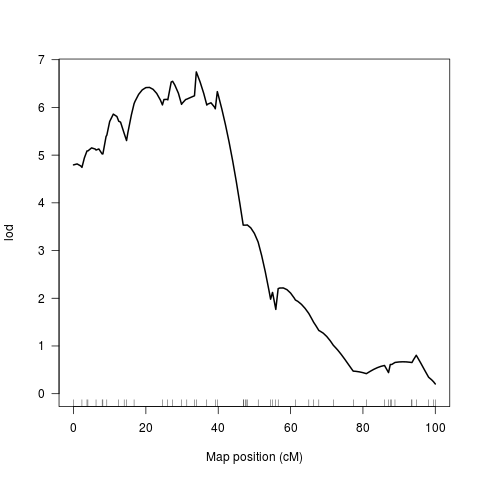

In [28]:
%%R

library(qtl)
data = read.cross('csv', file = 'BC_dominant_cross.csv', estimate.map=F, 
                  crosstype='bc')
print(summary(data))
data = calc.genoprob(data, step=1, error.prob=0.001)
#data=jittermap(data)
out.mr = scanone(data, method='em')
print(summary(out.mr))
plot(out.mr)
plot(out.mr, chr=3)

## Evaluate pipeline

In [29]:
cross = pd.read_csv('BC_dominant_cross.csv', sep=',', header=0, skiprows=[1,2])
cross.head()

,phenotype,D1M1,D1M2,D1M3,D1M4,D1M5,D1M6,D1M7,D1M8,D1M9,...,D5M51,D5M52,D5M53,D5M54,D5M55,D5M56,D5M57,D5M58,D5M59,D5M60
0,0.539590,A,A,A,A,A,A,A,A,H,...,A,A,A,A,A,A,A,A,A,A
1,0.241569,H,H,H,H,H,H,H,H,H,...,A,A,A,A,A,A,A,A,A,H
2,0.321025,A,A,A,A,A,A,A,A,A,...,A,A,A,A,A,A,A,A,A,A
3,-1.419005,H,H,H,H,H,H,H,H,H,...,A,A,A,A,A,A,A,A,A,A
4,0.102149,A,A,A,A,A,A,A,A,A,...,A,A,A,A,A,A,A,A,A,A


In [30]:
# prepare Y and drop
y = cross['phenotype']
cross = cross.drop('phenotype', axis=1)
cross.head()

,D1M1,D1M2,D1M3,D1M4,D1M5,D1M6,D1M7,D1M8,D1M9,D1M10,...,D5M51,D5M52,D5M53,D5M54,D5M55,D5M56,D5M57,D5M58,D5M59,D5M60
0,A,A,A,A,A,A,A,A,H,H,...,A,A,A,A,A,A,A,A,A,A
1,H,H,H,H,H,H,H,H,H,H,...,A,A,A,A,A,A,A,A,A,H
2,A,A,A,A,A,A,A,A,A,A,...,A,A,A,A,A,A,A,A,A,A
3,H,H,H,H,H,H,H,H,H,H,...,A,A,A,A,A,A,A,A,A,A
4,A,A,A,A,A,A,A,A,A,A,...,A,A,A,A,A,A,A,A,A,A


In [31]:
#prepare_array
d = {'A':0, 'H':1}
cross_numeric = cross.replace(to_replace=d)
cross_numeric.head()

,D1M1,D1M2,D1M3,D1M4,D1M5,D1M6,D1M7,D1M8,D1M9,D1M10,...,D5M51,D5M52,D5M53,D5M54,D5M55,D5M56,D5M57,D5M58,D5M59,D5M60
0,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


LASSOCV

In [32]:
from sklearn.model_selection import train_test_split
X = cross_numeric.values
y = y.values

weights, scores = mlQTLs_analysis(X, y)

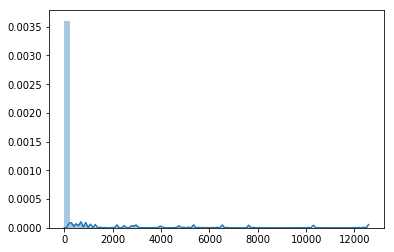

In [33]:
vals =weights*scores
sns.distplot(vals)
plt.show()

In [34]:
print(np.percentile(vals, q=[50, 75, 90, 95, 99]))
q = np.percentile(vals, q=99)
np.median(vals)

[  6.59450235e-02   5.86721285e+00   1.94711735e+02   1.00985720e+03
   6.90054557e+03]


0.065945023451779466

In [35]:
new_frame = pd.DataFrame({'markers_ID': cross_numeric.columns, 'Vals' :vals})
new_frame.head()

,Vals,markers_ID
0,8.044379e+01,D1M1
1,6.553777e+03,D1M2
2,5.052641e+00,D1M3
3,4.851972e-14,D1M4
4,3.925338e+01,D1M5


In [36]:
new_frame.sort_values(by='Vals', ascending=False).head()

,Vals,markers_ID
121,12577.105185,D3M19
124,10324.899016,D3M22
105,7604.590227,D3M3
1,6553.777310,D1M2
117,5364.078462,D3M15


## Final resolution

**Use np.sum for the scores.
You can use np.exp2(w+s) for the score and identify the most significant marker**

This option works kind of well with small effects single QTLs (ration 0.6 you can still identify good markers)
It would be interesting to evaluate the number of iterations depending on the QTL effect.

BTW you should check the LassoCV coefficient distribution as well.

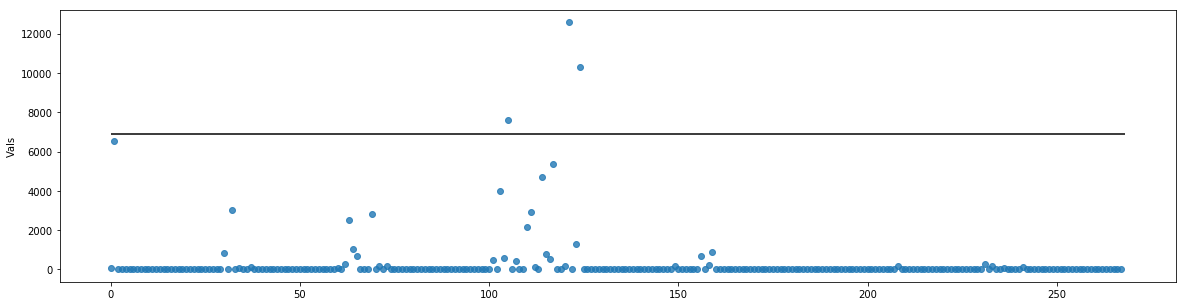

In [37]:
plt.figure(figsize=(20,5))
sns.regplot(x=np.array(np.arange(len(vals))), y=new_frame['Vals'], scatter=True, 
            fit_reg=False)#, lowess=True)
plt.hlines(q, xmin=0, xmax=len(vals))
plt.show()

In [23]:
cross2 = pd.read_csv('BC_dominant_cross.csv', sep=',', header=0)#, skiprows=[1])
cross2.head()

,phenotype,D1M1,D1M2,D1M3,D1M4,D1M5,D1M6,D1M7,D1M8,D1M9,...,D5M51,D5M52,D5M53,D5M54,D5M55,D5M56,D5M57,D5M58,D5M59,D5M60
0,NaN,1,1,1,1,1,1,1,1,1,...,5,5,5,5,5,5,5,5,5,5
1,NaN,0,2.62173577444628,5.01937290653586,5.69722600514069,9.25763206556439,9.30899553233758,10.2975925849751,13.9797631721012,21.2121122679673,...,98.5731199756265,98.7867804709822,100.406962092966,102.721767704934,105.546203618869,113.453879579902,114.232851443812,114.491787934676,118.026909101754,120
2,0.539590,A,A,A,A,A,A,A,A,H,...,A,A,A,A,A,A,A,A,A,A
3,0.241569,H,H,H,H,H,H,H,H,H,...,A,A,A,A,A,A,A,A,A,H
4,0.321025,A,A,A,A,A,A,A,A,A,...,A,A,A,A,A,A,A,A,A,A


In [25]:
sign_markers=new_frame[new_frame['Vals']>=q]['markers_ID'].values
print(sign_markers)
cross2[sign_markers].head()

['D1M2' 'D3M3' 'D3M12']


,D1M2,D3M3,D3M12
0,1,3,3
1,2.62173577444628,3.72343258932233,16.7359885759652
2,A,A,A
3,H,H,H
4,A,H,A


In [26]:
cross2['D3M14'].head()

0                   3
1    26.0645198402926
2                   A
3                   H
4                   A
Name: D3M14, dtype: object

Simulation cell:

%%R
library(qtl)
L=c(50, 75, 100, 80, 120)
set.seed(42)
markers_chr = ceiling(rnorm(5, 1000, 200))
set.seed(42)
mapD=sim.map(L, markers_chr, eq.spacing=F, include.x=F)
plot(mapD)
bc_model = rbind(c(2, 20, 5))
BC_cross = sim.cross(mapD, n.ind=250, type='bc', model = bc_model)
boxplot(BC_cross$pheno)
print(summary(BC_cross))
write.cross(BC_cross, format='csv', filestem='BC_dominant_cross')

When using these parameters the algorithm identify 6 markers (['D2M247' 'D2M248' 'D2M255' 'D2M256' 'D2M269' 'D2M270') significant (coeff > 0) located between 19 and 21 cM.

For this experiment I used the median coefficient and w*s as score

## Interacting QTL and epistasis simulation and evaluation

1. Interacting QTL on different chromosomes: practically equivalent to R qtl (nullmodel = rbind(c(2, 40, 0.6), c(5, 100, 0.6)))
2. Epistatic effect: identify only 1 peak (equivalent to R QTL)
        see sim.crros documentation
3. Interacting QTL same chromosome: Identify them, better than R qtl that identify two peaks with all the chromosome significant


The next cells are for two interacting QTLs

    Backcross

    No. individuals:    250 

    No. phenotypes:     1 
    Percent phenotyped: 100 

    No. chromosomes:    5 
        Autosomes:      1 2 3 4 5 

    Total markers:      268 
    No. markers:        65 38 50 55 60 
    Percent genotyped:  100 
    Genotypes (%):      AA:52.1  AB:47.9 


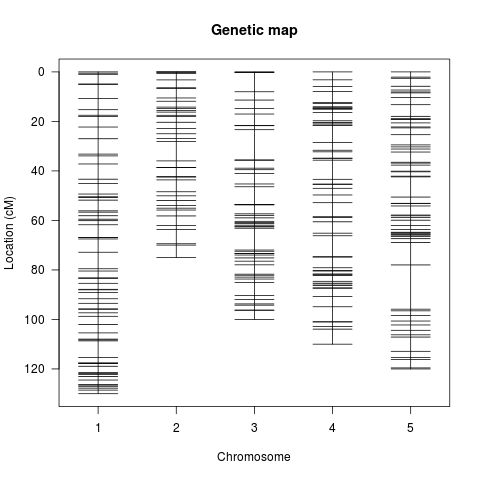

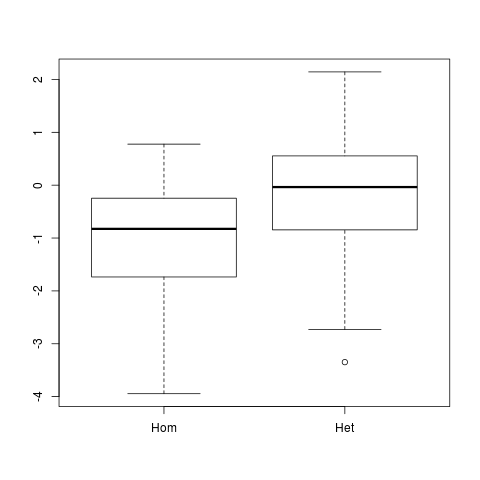

In [178]:
%%R
library(qtl)
L=c(130, 75, 100, 110, 120)
set.seed(42)
#markers_chr = ceiling(rnorm(5, 1000, 200))
set.seed(42)
mapD=sim.map(L, ceiling(L/2), eq.spacing=F, include.x=F)
plot(mapD)
nullmodel = rbind(c(2, 20, 0.6), c(4, 65, -0.6))
epi_cross = sim.cross(mapD, n.ind=250, type='bc', model = nullmodel)

#qtlg=epi_cross$qtlgeno
#wh=qtlg[,1]==1 & qtlg[,1]==1
#epi_cross$pheno[wh,1]=epi_cross$pheno[wh, 1]-1

#p1 = epi_cross$pheno[wh, 1]
#p2 = epi_cross$pheno[!wh, 1]
boxplot(p1, p2, names=c('Hom', 'Het'))
print(summary(epi_cross))
write.cross(epi_cross, format='csv', filestem='epi_cross')

In [179]:
# main function
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample
from sklearn.datasets import make_regression
from sklearn.svm import LinearSVR
from sklearn.linear_model import LassoCV
from scipy import stats

def optimize_weights(X, y, cv):
    alphas = 1/(X.shape[0]*np.logspace(-5, 4, 10))
    model = LassoCV(alphas=alphas, cv = cv, random_state=42, 
                    precompute=True, positive=True, n_jobs=-1)
    model.fit(X,y)
    return model.coef_
    
def mlQTLs_analysis(X, y, n_estimators=100,
                    max_samples = 0.8, cv = 5, random_state=42):
    '''main function that will call the other functions'''
    all_w = []
    for i in range(n_estimators):
        # loop over the number of estimators
        X_res, y_res = resample(X, y,
                                n_samples=int(np.ceil(X.shape[0]*max_samples)),
                                replace=True, random_state=i*random_state)
        w = optimize_weights(X_res, y_res, cv=cv)
        all_w.append(w)
    # now you will need to:
        #1) Calculate the stability score for each feature
        #2) Sum the scores
        #3) for optimization purpose I will return the full  coeff_array
    all_w = np.array(all_w)
    w= np.percentile(all_w, 95, axis=0)
    bin_matrix = np.where(all_w>0, 1, 0)
    s_scores = np.sum(bin_matrix, axis=0)/n_estimators
    return w, s_scores

In [180]:
cross = pd.read_csv('epi_cross.csv', sep=',', header=0, skiprows=[1,2])
cross.head()

,phenotype,D1M1,D1M2,D1M3,D1M4,D1M5,D1M6,D1M7,D1M8,D1M9,...,D5M51,D5M52,D5M53,D5M54,D5M55,D5M56,D5M57,D5M58,D5M59,D5M60
0,-2.105030,H,H,H,H,H,H,H,H,H,...,H,H,H,H,H,H,H,H,H,H
1,-0.921401,A,A,A,A,A,A,A,A,H,...,A,A,A,A,A,A,A,A,A,A
2,1.441138,A,A,A,A,A,A,A,A,A,...,H,H,H,H,H,H,H,H,H,H
3,0.739252,H,H,H,H,H,H,H,H,H,...,A,A,A,A,A,A,A,A,A,A
4,0.342171,A,A,A,A,A,A,A,A,A,...,H,H,H,H,H,H,H,H,H,H


In [181]:
# prepare Y and drop
y = cross['phenotype']
cross = cross.drop('phenotype', axis=1)
cross.head()

,D1M1,D1M2,D1M3,D1M4,D1M5,D1M6,D1M7,D1M8,D1M9,D1M10,...,D5M51,D5M52,D5M53,D5M54,D5M55,D5M56,D5M57,D5M58,D5M59,D5M60
0,H,H,H,H,H,H,H,H,H,H,...,H,H,H,H,H,H,H,H,H,H
1,A,A,A,A,A,A,A,A,H,H,...,A,A,A,A,A,A,A,A,A,A
2,A,A,A,A,A,A,A,A,A,A,...,H,H,H,H,H,H,H,H,H,H
3,H,H,H,H,H,H,H,H,H,H,...,A,A,A,A,A,A,A,A,A,A
4,A,A,A,A,A,A,A,A,A,A,...,H,H,H,H,H,H,H,H,H,H


In [182]:
#prepare_array
d = {'A':0, 'H':1}
cross_numeric = cross.replace(to_replace=d)
cross_numeric.head()

,D1M1,D1M2,D1M3,D1M4,D1M5,D1M6,D1M7,D1M8,D1M9,D1M10,...,D5M51,D5M52,D5M53,D5M54,D5M55,D5M56,D5M57,D5M58,D5M59,D5M60
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [183]:
from sklearn.model_selection import train_test_split
X = cross_numeric.values
y = y.values

weights, scores = mlQTLs_analysis(X, y, n_estimators=100)

In [184]:
vals =np.exp(weights+scores)
q = np.percentile(vals, q=99)

new_frame = pd.DataFrame({'markers_ID': cross_numeric.columns, 'Vals' :vals})

new_frame[new_frame['Vals']>=q]

,Vals,markers_ID
65,2.234130,D2M1
80,2.233448,D2M16
81,2.034420,D2M17


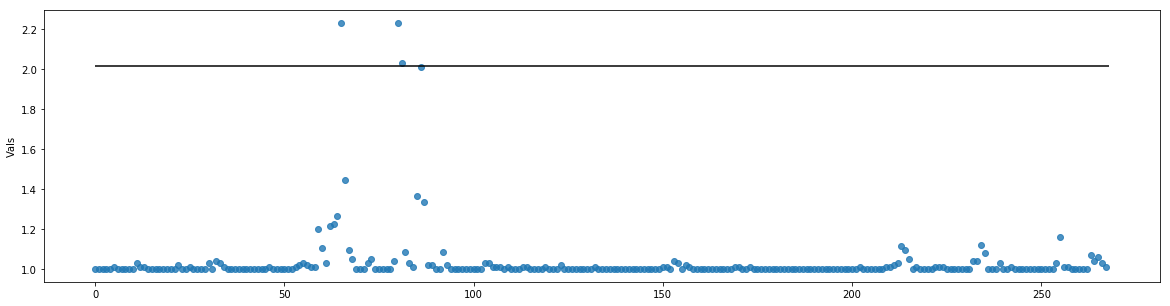

In [185]:
plt.figure(figsize=(20,5))
sns.regplot(x=np.array(np.arange(len(vals))), y=new_frame['Vals'], scatter=True, 
            fit_reg=False)#, lowess=True)
plt.hlines(q, xmin=0, xmax=len(vals))
plt.show()

In [186]:
cross2 = pd.read_csv('epi_cross.csv', sep=',', header=0)#, skiprows=[1])
cross2.head()

sign_markers=new_frame[new_frame['Vals']>=q]['markers_ID'].values
print(sign_markers)
cross2[sign_markers].head()

['D2M1' 'D2M16' 'D2M17']


,D2M1,D2M16,D2M17
0,2,2,2
1,0,20.3464961028658,22.8913777100388
2,H,H,H
3,A,A,A
4,H,H,H


 --Read the following data:
	 250  individuals
	 268  markers
	 1  phenotypes
 --Cross type: bc 
    Backcross

    No. individuals:    250 

    No. phenotypes:     1 
    Percent phenotyped: 100 

    No. chromosomes:    5 
        Autosomes:      1 2 3 4 5 

    Total markers:      268 
    No. markers:        65 38 50 55 60 
    Percent genotyped:  100 
    Genotypes (%):      AA:52.1  AB:47.9 
         chr    pos   lod
D1M2       1  0.513 1.148
c2.loc21   2 21.000 2.958
D3M43      3 85.048 0.791
c4.loc64   4 64.000 3.746
D5M19      5 30.295 0.300


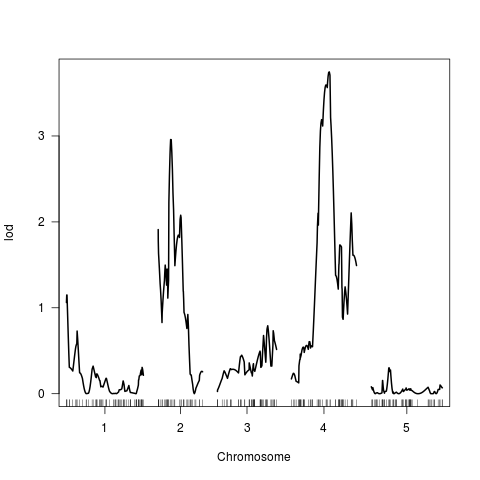

In [187]:
%%R

library(qtl)
data = read.cross('csv', file = 'epi_cross.csv', estimate.map=F, 
                  crosstype='bc')
print(summary(data))
data = calc.genoprob(data, step=1, error.prob=0.001)
#data=jittermap(data)
out.mr = scanone(data, method='em')
print(summary(out.mr))
plot(out.mr)